In [2]:
import warnings
warnings.filterwarnings('ignore') 
from torchvision.utils import save_image
import numpy as np
import glob
import torch
from matplotlib import pyplot as plt
from torchvision.io import decode_image
from PIL import Image



In [3]:
def srgb_to_linear(image_tensor: torch.Tensor) -> torch.Tensor:
    """
    Converts a batch of sRGB image tensors to linear RGB.
    
    Formula:
    if C <= 0.04045: L = C / 12.92
    if C > 0.04045:  L = ((C + 0.055) / 1.055) ** 2.4
    
    Args:
        image_tensor: A tensor (e.g., shape [B, C, H, W]) in sRGB space [0, 1].

    Returns:
        A tensor of the same shape in linear RGB space.
    """

    # Values for the linear part of the sRGB curve
    limit = 0.04045
    
    # torch.where(condition, value_if_true, value_if_false)
    return torch.where(
        image_tensor <= limit,
        image_tensor / 12.92,
        torch.pow((image_tensor + 0.055) / 1.055, 2.4)
    )

def linear_to_srgb(image_tensor: torch.Tensor, epsilon: float = 1e-6)-> torch.Tensor:
    """
    Converts a batch of linear RGB image tensors to sRGB.
    
    Formula:
    if L <= 0.0031308: C = L * 12.92
    if L > 0.0031308:  C = 1.055 * (L ** (1/2.4)) - 0.055
    
    Args:
        image_tensor: A tensor (e.g., shape [B, C, H, W]) in linear RGB [0, 1].
        epsilon: A small value to add before the power function 
                 to avoid NaNs when backpropagating gradients through zero.

    Returns:
        A tensor of the same shape in sRGB space.
    """
    # Values for the linear part of the sRGB curve
    limit = 0.0031308

    # Add epsilon for numerical stability, clamp to avoid negative values
    # from floating point inaccuracies before the power function.
    linear_clipped = torch.clamp(image_tensor, min=0.0)
    
    # torch.where(condition, value_if_true, value_if_false)
    return torch.where(
        linear_clipped <= limit,
        linear_clipped * 12.92,
        1.055 * torch.pow(linear_clipped + epsilon, 1.0 / 2.4) - 0.055
    )

In [16]:
def srgb_to_oklab(im):
    M1 = torch.tensor([[0.4122214708,0.5363325363,0.0514459929],
                   [0.2119034982,0.6806995451,0.1073969566],
                   [0.0883024619,0.2817188376,0.6299787005]])
    M2 = torch.tensor([[0.2104542553,0.7936177850, -0.0040720468],
        [1.9779984951,-2.4285922050,0.4505937099],
        [0.0259040371,0.7827717662,-0.8086757660]])

    return (M2@torch.pow(M1@srgb_to_linear(im).unsqueeze(-1),1/3)).squeeze(-1)

def gaussian(x,mean=0.37, var=0.08):
    return torch.exp(-(x-mean)**2/(2*var**2))

def filter(im):
    i = srgb_to_oklab(im)
    lum = i[:,:,0]
    m = max(torch.mean(lum[lum>0.1]),0.5)
    return gaussian(lum,mean=m,var=1.25)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

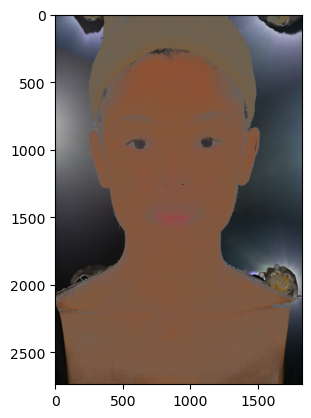

In [17]:
def lighten(inp, out):
    buff = inp
    im = out
    mag_buff = filter(buff)
    mag_im = filter(im)
    
    buff[mag_buff<mag_im,:] = im[mag_buff<mag_im,:]
    return buff
def darken(inp, out):
    buff = inp
    im = out
    mag_buff = torch.norm(buff,dim=-1)
    mag_im = torch.norm(im,dim=-1)
    buff[mag_buff>mag_im,:] = im[mag_buff>mag_im,:]
    return buff
path = "./OLAT_ColourCorrected_PNG/*.png"
files = glob.glob(path)
buff = torch.permute(decode_image(files[0]),(1,2,0)).float()/255
#images_list = []
for file in files:
    im = torch.permute(decode_image(file),(1,2,0)).float()/255
    #images_list.append(im)
    buff = lighten(buff, im)
#images = torch.stack(images_list)
save_image(torch.permute(buff,(2,0,1)), "./OLAT_lighten/all.png")
plt.imshow(buff)


# for i in range(0,len(files),13):
#     buff2 = torch.zeros_like(torch.permute(decode_image(files[0]),(1,2,0))).float().cuda()
#     for file in range(len(files)):
#         if file-i<=13 and file-i>0:
#             continue
#         else:
#             im = torch.permute(decode_image(files[file]),(1,2,0)).float().cuda()/255
#             buff2 = lighten(buff2, im)
#     save_image((torch.permute(buff2.cpu(),(2,0,1))), f"./OLAT_lighten/2{i}.png")
#     print(i)
    
# plt.imshow(buff2.cpu())

# path = "./OLAT_lighten/*.png"
# files = glob.glob(path)
# buff = torch.ones_like(torch.permute(decode_image(files[0]),(1,2,0)).float()/255)
# for file in files:
#     im = torch.permute(decode_image(file),(1,2,0)).float()/255
#     buff = darken(buff, im)
# plt.imshow(buff)

    
            
    